In [1]:
from PIL import Image
import numpy as np

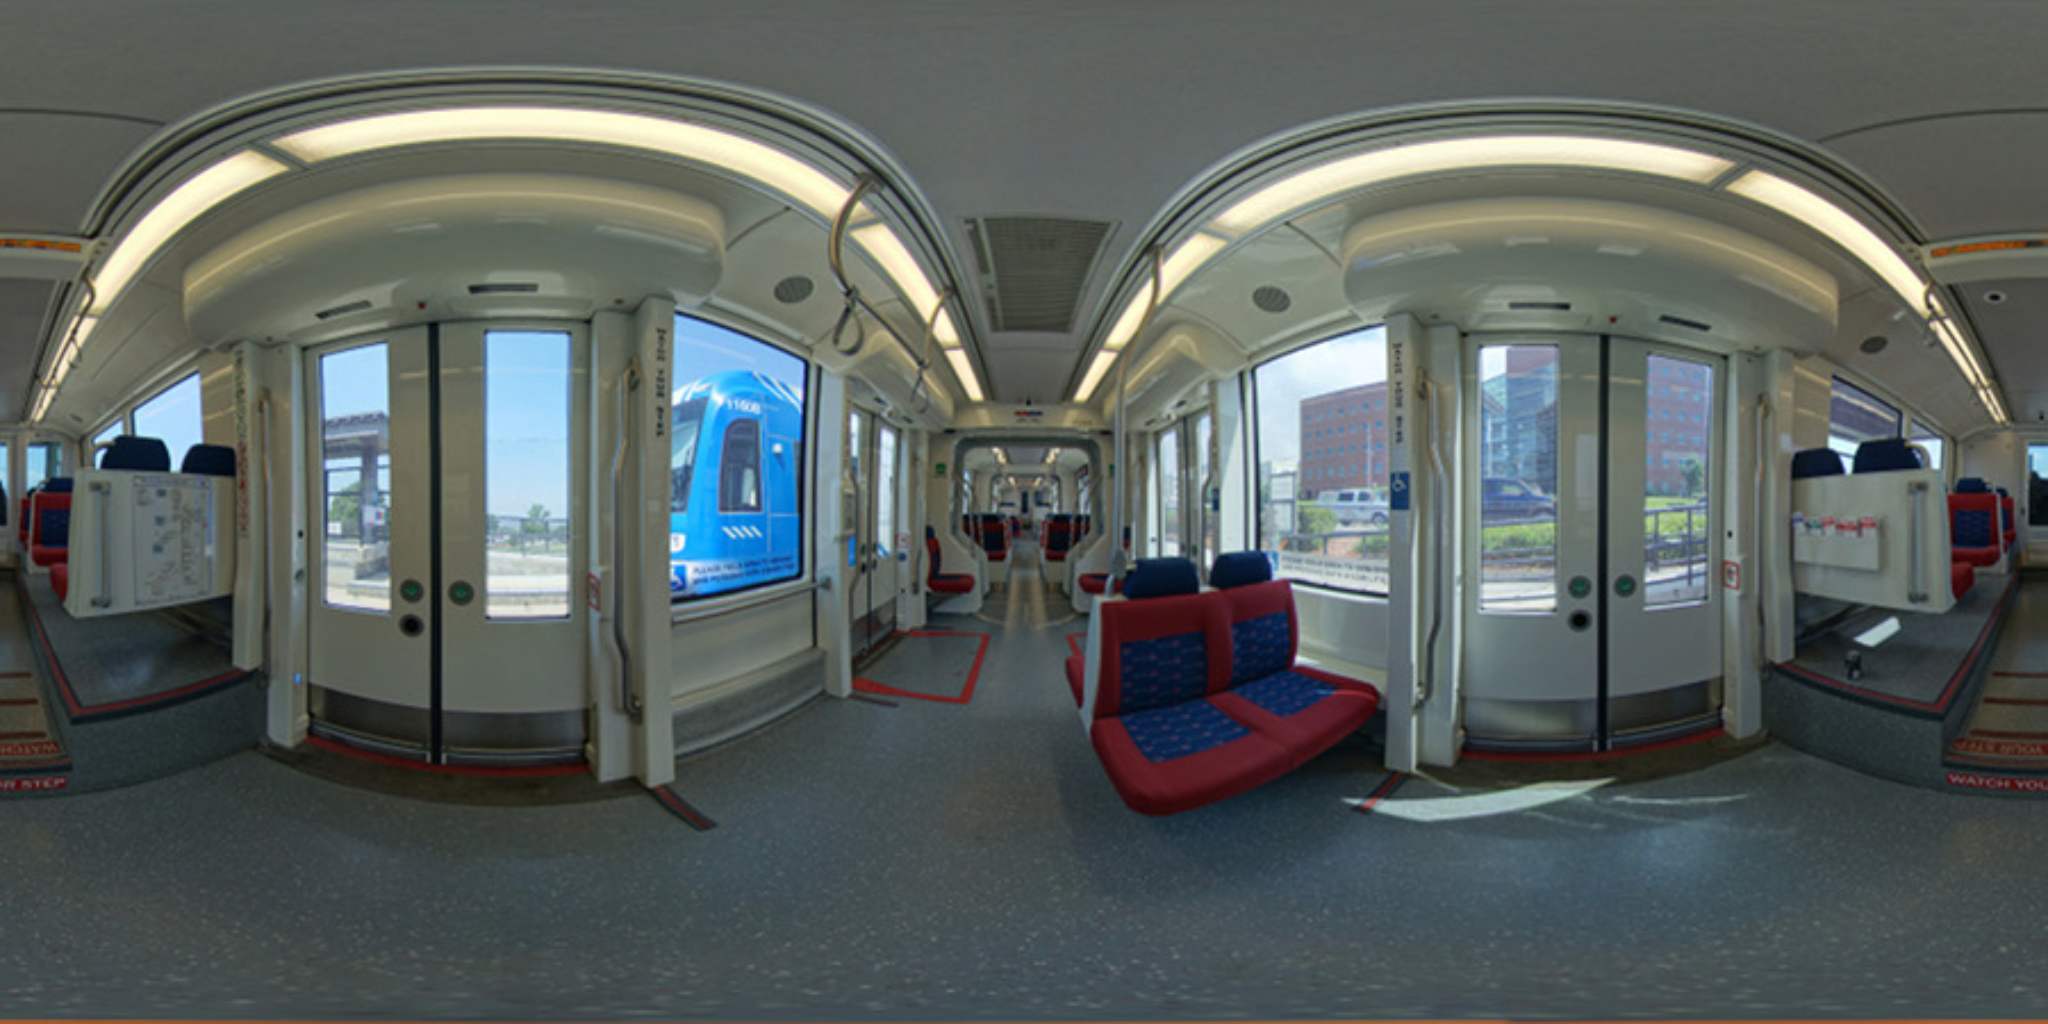

In [2]:
test_photo_path = "./stimulis/001.png"
im = Image.open(test_photo_path)
im

以下是我自己写的球面坐标->平面直角坐标转换函数

In [3]:
phi = 90   #0 <= phi <= 360
theta = 90 #0 <= theta <= 180
def sphere_to_descart_phi(phi, im, reverse_axe = True):
    if reverse_axe == True:
        width = im.size[0]
        y = width - width * phi/360
        return (int(y))
def sphere_to_descart_theta(theta, im, reverse_axe = True):
    if reverse_axe == True:
        height = im.size[1]
        x = (1 - np.cos(theta*np.pi/180)) * (height/2)
        return (int(x))
def sphere_to_descart(phi, theta, im, reverse_axe = True):
    if reverse_axe == True:
        return (sphere_to_descart_theta(theta, im),sphere_to_descart_phi(phi, im))

In [4]:
sphere_to_descart(phi, theta, im)

(511, 1536)

对于指定的视方向和视角，计算出360图像的对应区域

In [52]:
def point_to_view(phi, theta, angle):
    up = (theta - angle) % 180
    down = (theta + angle) % 180
    if theta - angel < 0:
        left = (phi - angle) % 360
        right = (phi + angle) % 360
    return 

以下是从 [Stacksoverflow](https://stackoverflow.com/questions/29678510/convert-21-equirectangular-panorama-to-cube-map) 找来的代码
该算法使用立方体投影，理论上算法比球形投影简单

In [ ]:
import sys
from PIL import Image
from math import pi,sin,cos,tan,atan2,hypot,floor
from numpy import clip

def cot(angle):
    return 1/tan(angle)

# Project polar coordinates onto a surrounding cube
# assume ranges theta is [0,pi] with 0 the north poll, pi south poll
# phi is in range [0,2pi] 
def projection(theta,phi): 
        if theta<0.615:
            return projectTop(theta,phi)
        elif theta>2.527:
            return projectBottom(theta,phi)
        elif phi <= pi/4 or phi > 7*pi/4:
            return projectLeft(theta,phi)
        elif phi > pi/4 and phi <= 3*pi/4:
            return projectFront(theta,phi)
        elif phi > 3*pi/4 and phi <= 5*pi/4:
            return projectRight(theta,phi)
        elif phi > 5*pi/4 and phi <= 7*pi/4:
            return projectBack(theta,phi)

def projectLeft(theta,phi):
        x = 1
        y = tan(phi)
        z = cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Left",x,y,z)

def projectFront(theta,phi):
        x = tan(phi-pi/2)
        y = 1
        z = cot(theta) / cos(phi-pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Front",x,y,z)

def projectRight(theta,phi):
        x = -1
        y = tan(phi)
        z = -cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Right",x,-y,z)

def projectBack(theta,phi):
        x = tan(phi-3*pi/2)
        y = -1
        z = cot(theta) / cos(phi-3*pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Back",-x,y,z)

def projectTop(theta,phi):
        # (a sin θ cos ø, a sin θ sin ø, a cos θ) = (x,y,1)
        a = 1 / cos(theta)
        x = tan(theta) * cos(phi)
        y = tan(theta) * sin(phi)
        z = 1
        return ("Top",x,y,z)

def projectBottom(theta,phi):
        # (a sin θ cos ø, a sin θ sin ø, a cos θ) = (x,y,-1)
        a = -1 / cos(theta)
        x = -tan(theta) * cos(phi)
        y = -tan(theta) * sin(phi)
        z = -1
        return ("Bottom",x,y,z)

# Convert coords in cube to image coords 
# coords is a tuple with the side and x,y,z coords
# edge is the length of an edge of the cube in pixels
def cubeToImg(coords,edge):
    if coords[0]=="Left":
        (x,y) = (int(edge*(coords[2]+1)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Front":
        (x,y) = (int(edge*(coords[1]+3)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Right":
        (x,y) = (int(edge*(5-coords[2])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Back":
        (x,y) = (int(edge*(7-coords[1])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Top":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(1+coords[2])/2) )
    elif coords[0]=="Bottom":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(5-coords[2])/2) )
    return (x,y)

# convert the in image to out image
def convert(imgIn,imgOut):
    inSize = imgIn.size
    outSize = imgOut.size
    inPix = imgIn.load()
    outPix = imgOut.load()
    edge = inSize[0]/4   # the length of each edge in pixels
    for i in range(inSize[0]):
        for j in range(inSize[1]):
            pixel = inPix[i,j]
            phi = i * 2 * pi / inSize[0]
            theta = j * pi / inSize[1]
            res = projection(theta,phi)
            (x,y) = cubeToImg(res,edge)
            #if i % 100 == 0 and j % 100 == 0:
            #   print i,j,phi,theta,res,x,y
            if x >= outSize[0]:
                #print "x out of range ",x,res
                x=outSize[0]-1
            if y >= outSize[1]:
                #print "y out of range ",y,res
                y=outSize[1]-1
            outPix[x,y] = pixel

# get x,y,z coords from out image pixels coords
# i,j are pixel coords
# face is face number
# edge is edge length
def outImgToXYZ(i,j,face,edge):
    a = 2.0*float(i)/edge
    b = 2.0*float(j)/edge
    if face==0: # back
        (x,y,z) = (-1.0, 1.0-a, 3.0 - b)
    elif face==1: # left
        (x,y,z) = (a-3.0, -1.0, 3.0 - b)
    elif face==2: # front
        (x,y,z) = (1.0, a - 5.0, 3.0 - b)
    elif face==3: # right
        (x,y,z) = (7.0-a, 1.0, 3.0 - b)
    elif face==4: # top
        (x,y,z) = (b-1.0, a -5.0, 1.0)
    elif face==5: # bottom
        (x,y,z) = (5.0-b, a-5.0, -1.0)
    return (x,y,z)

# convert using an inverse transformation
def convertBack(imgIn,imgOut):
    inSize = imgIn.size
    outSize = imgOut.size
    inPix = imgIn.load()
    outPix = imgOut.load()
    edge = int(inSize[0]/4)   # the length of each edge in pixels
    for i in range(outSize[0]):
        face = int(i/edge) # 0 - back, 1 - left 2 - front, 3 - right
        if face==2:
            rng = range(0,edge*3)
        else:
            rng = range(edge,edge*2)

        for j in rng:
            if j<edge:
                face2 = 4 # top
            elif j>=2*edge:
                face2 = 5 # bottom
            else:
                face2 = face

            (x,y,z) = outImgToXYZ(i,j,face2,edge)
            theta = atan2(y,x) # range -pi to pi
            r = hypot(x,y)
            phi = atan2(z,r) # range -pi/2 to pi/2
            # source img coords
            uf = ( 2.0*edge*(theta + pi)/pi )
            vf = ( 2.0*edge * (pi/2 - phi)/pi)
            # Use bilinear interpolation between the four surrounding pixels
            ui = floor(uf)  # coord of pixel to bottom left
            vi = floor(vf)
            u2 = ui+1       # coords of pixel to top right
            v2 = vi+1
            mu = uf-ui      # fraction of way across pixel
            nu = vf-vi
            # Pixel values of four corners

            A = inPix[int(ui % inSize[0]),int(clip(vi,0,inSize[1]-1))]
            B = inPix[int(u2 % inSize[0]),int(clip(vi,0,inSize[1]-1))]
            C = inPix[int(ui % inSize[0]),int(clip(v2,0,inSize[1]-1))]
            D = inPix[int(u2 % inSize[0]),int(clip(v2,0,inSize[1]-1))]
            # interpolate
            (r,g,b) = (
              A[0]*(1-mu)*(1-nu) + B[0]*(mu)*(1-nu) + C[0]*(1-mu)*nu+D[0]*mu*nu,
              A[1]*(1-mu)*(1-nu) + B[1]*(mu)*(1-nu) + C[1]*(1-mu)*nu+D[1]*mu*nu,
              A[2]*(1-mu)*(1-nu) + B[2]*(mu)*(1-nu) + C[2]*(1-mu)*nu+D[2]*mu*nu )

            outPix[i,j] = (int(round(r)),int(round(g)),int(round(b)))

imgIn = Image.open(test_photo_path)
inSize = imgIn.size
imgOut = Image.new("RGB",(inSize[0],int(inSize[0]*3/4)),"black")
convertBack(imgIn,imgOut)
imgOut.save(sys.argv[1].split('.')[0]+"Out2.png")
imgOut.show()

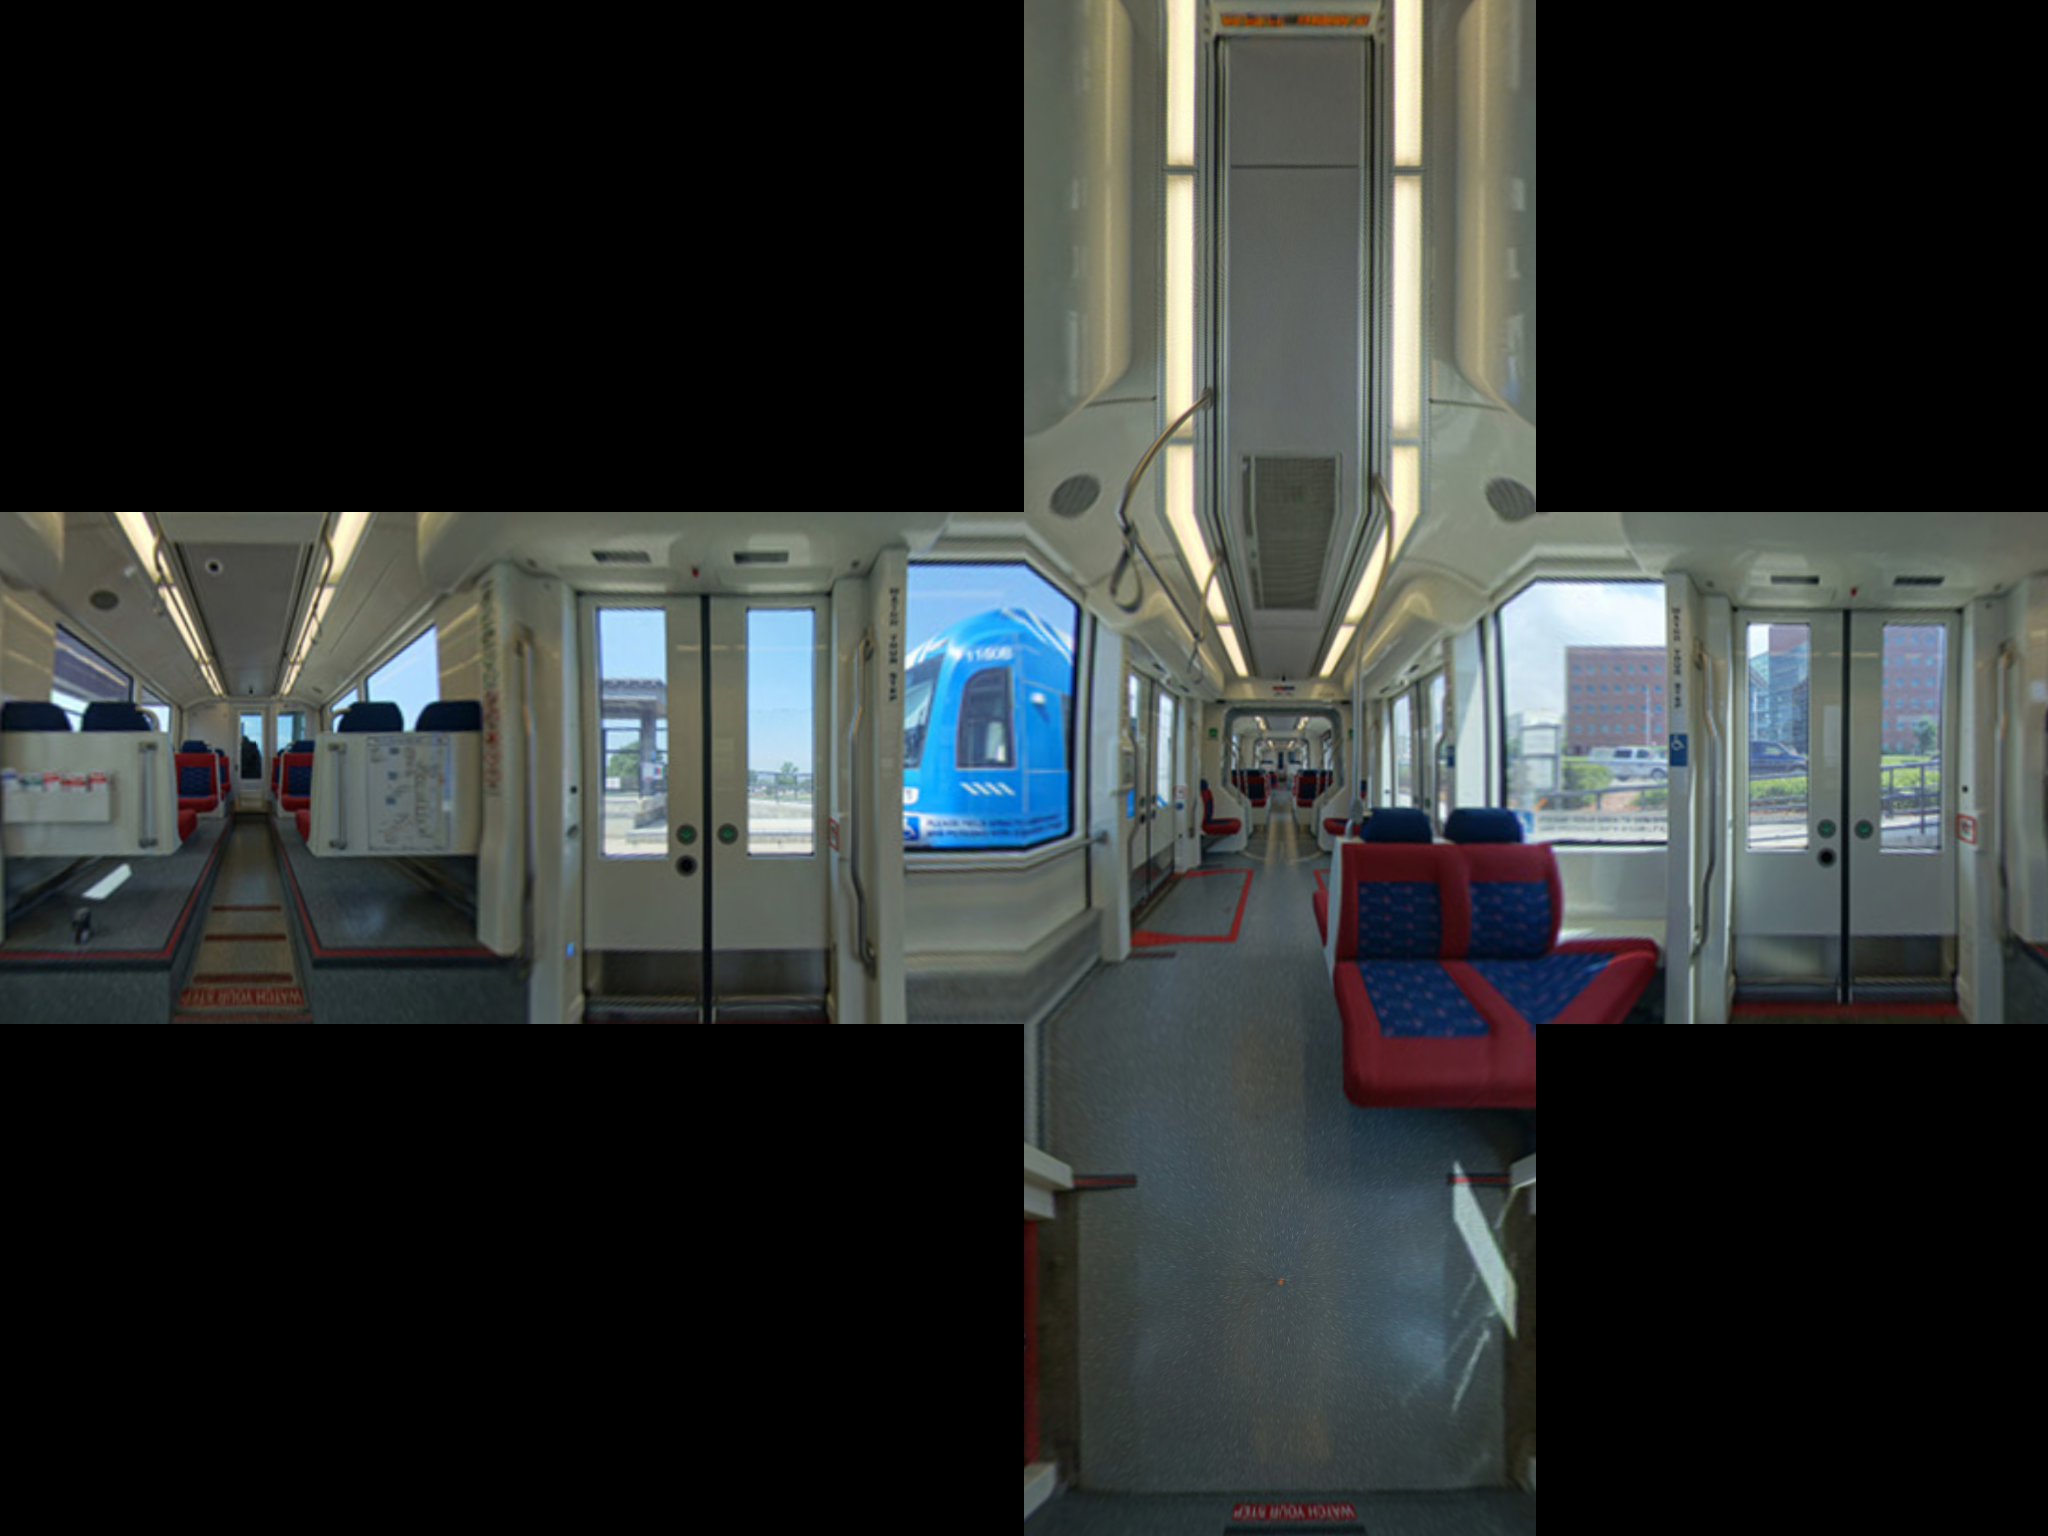

In [4]:
imgOut

In [7]:
这个算法，很慢很慢，但是效果还可以

1536.0